In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pprint
import pydot
import seaborn as sns
from squeemtools.other import Dictionaries
from scipy.stats import entropy, zscore
from sklearn.model_selection import train_test_split

In [2]:
def my_entropy(series):
    '''Calculate entropy from given list'''
    values, counts = np.unique(series,return_counts=True)
    denom = sum(counts)
    if denom != 0: return -np.sum([(cnt/denom) * np.log2(cnt/denom) for cnt in counts])
    else: return 0

def total_entropy(df : pd.DataFrame) -> float:
    '''Gets the entropy of the entire dataset'''
    label = df.keys()[-1]

    # Gets the total entropy of the dataframe
    ent = my_entropy(df[label])
    return ent

def attribute_entropy(df : pd.DataFrame,attribute : str) -> float:
    '''Gets the entropy of a specific attribute'''
    label = df.keys()[-1]
    variables = df[attribute].unique()

    # Gets the entropy of the attribute
    ent = np.array([-(len(df[df[attribute] == variable]) / len(df)) * my_entropy(df[df[attribute]==variable][label]) for variable in variables]).sum()
    return abs(ent)

def create_tree(df : pd.DataFrame,depth : int=-1) -> dict:
    '''ID3 decision tree creating algorithm. Requires df to be a pd.DataFrame, and that the label of the data is the last column
       depth is how tall you want the tree to be. If left at default, goes to maximum length'''
    label = df.keys()[-1]
    
    # There are only 2 columns left, nothing to split on
    # Reached the desired depth
    if len(df.columns) == 1 or depth == 0:
        # Take the value that is the most common as the label
        tree = df[label].mode()[0]
    else:
        #Get attribute with maximum information gain
        node = df.keys()[:-1][np.argmax([total_entropy(df)-attribute_entropy(df,key) for key in df.keys()[:-1]])]

        #Get distinct value of that attribute
        att_values = df[node].unique()

        # Start of tree/current node
        tree = {}

        # If data is numerical
        if(is_number(att_values[0])):
            # Sort the values
            small = df.sort_values(by=[node,label])

            # Get the values and labels
            values = small[node].values
            labels = small[label].values

            # Locations to split on
            split_locations = []
            # Current label of split
            current_label = labels[0]

            # Populate a list of splitting locations
            for index in range(len(labels) - 1):
                # If the next value has the same label
                if labels[index + 1] == current_label:
                    continue
                # If the next value has a different label
                else:
                    # Change the label, add a split location
                    current_label = labels[index + 1]
                    split_locations.append(index + 1)

            # Entropy of the labels
            labels_ent = my_entropy(labels)
            # Best average entropy of left and right
            avg_best = labels_ent
            # Best index to split on
            best_index = -1
            # Calculate entropy of every split
            for index in split_locations:
                # Calculate entropy of left and right split
                ent_left = my_entropy(labels[:index])
                ent_right = my_entropy(labels[index:])

                # Calculate weighted entropy
                weighted_ent = (labels_ent - (ent_left * 1/len(labels[:index])) + labels_ent - (ent_right * 1/len(labels[index:]))) / 2

                # If the entropy of the left and right is lower than the best, then it's the new best
                # Also set the best index to split on
                if weighted_ent < avg_best:
                    avg_best = weighted_ent
                    best_index = index
            
            # Create the labels for the node
            node_label_l = f"{node} <= {values[best_index]}"
            node_label_r = f"{node} > {values[best_index]}"

            # Create subtables from the split
            subtable_l = small[small[node] <= values[best_index]]
            subtable_l = subtable_l.drop(columns=node)
            subtable_r = small[small[node] > values[best_index]]
            subtable_r = subtable_r.drop(columns=node)

            # Get the counts and values of the subtables
            table_values_l, counts_l = np.unique(subtable_l[label],return_counts=True)
            table_values_r, counts_r = np.unique(subtable_r[label],return_counts=True)
            # If the left table has only one outcome
            if len(counts_l) == 1:
                tree[node_label_l] = table_values_l[0]
            # Left table has more outcomes
            elif len(subtable_l) != 0:
                tree[node_label_l] = create_tree(subtable_l,depth-1)
            # If the right table has only one outcome
            if len(counts_r) == 1:
                tree[node_label_r] = table_values_r[0]
            # Right table has more outcomes
            elif len(subtable_r) != 0:
                tree[node_label_r] = create_tree(subtable_r,depth-1)
        # Data is categorical
        else:
            # Add the node
            tree[node] = {}

            # Create the other nodes/leaves
            for att_value in att_values:
                # Create table with specific attribute
                subtable = df[df[node] == att_value].reset_index(drop=True)
                subtable = subtable.drop(columns=node)

                # Get how many outcomes there are for the attribute
                table_values,counts = np.unique(subtable[label],return_counts=True)

                # If there is only one outcome, add leaf
                if len(counts) == 1:
                    tree[node][att_value] = table_values[0]
                # If there is more than one outcome, need to create another node
                else:
                    tree[node][att_value] = create_tree(subtable,depth-1)
    return tree

def is_number(s) -> bool:
    try:
        float(s)
        return True
    except ValueError:
        return False

def classify_series(data : pd.Series,tree : dict):
    '''Given a series, returns the tree's classification of the series
       data is a pd.Series object, and tree is a dict created with the ID3 algorithm'''
    label = tree
    while isinstance(label,dict):
        #print()
        try:
            key = list(label.keys())[0]
            
            # Search for the threshold
            less_than = key.find("<")
            greater_than = key.find(">")
            
            # Checking key for less than
            if less_than != -1:
                # find the actual name of node (without less than)
                new_key = key[:less_than-1]
                # Threshold is value to check against
                threshold = float(key[less_than+3:])
                # Value from the data point
                value = data[new_key]
                # If the value is less than or equal to the threshold, it's the key
                if value <= threshold:
                    thing = key
                # Otherwise it's greater than the threshold
                else:
                    thing = f"{new_key} > {key[less_than+3:]}"
                # Move through the tree
                try:
                    label = label[thing]
                except:
                    return "Data point can't be classified", -1

            elif greater_than != -1:
                # find the actual name of node (without greater than)
                new_key = key[:greater_than-1]
                # Threshold is value to check against
                threshold = float(key[greater_than+2:])
                # Value from the data point
                value = data[new_key]
                # If the value is greater than the threshold, it's the key
                if value > threshold:
                    thing = key
                # Otherwise it's less than the threshold
                else:
                    thing = f"{new_key} <= {key[greater_than+2:]}"
                # Move through the tree
                try:
                    label = label[thing]
                except:
                    return "Data point can't be classified", -1
            # No thresholding (most likely cateogrical data)
            else:
                value = data[key]
                label = label[key][value]
        except:
            return "Data point can't be classified", -1
    return label

def find_tree_accuracy(data : pd.DataFrame,tree : dict) -> None:
    '''Given a dataframe, and tree, find the accuracy of the tree's classification'''
    correct = 0
    not_classified = 0
    classified_incorrect = 0
    label = data.keys()[-1] 
    for x in range(len(data)):
        result = classify_series(data.iloc[x],tree)
        if isinstance(result,tuple) and result[0] == "Data point can't be classified":
            not_classified += 1
        elif result == data.iloc[x][label]:
            correct += 1
        else:
            classified_incorrect += 1
    print(f"The accuracy of the ID3 tree on the training data was: {correct/len(data) * 100:.2f}%")
    print(f"The total number of data point{'s' if not_classified >1 else ''} that could not be classified was {not_classified}, {not_classified/len(data) * 100:.2f}% of the testing data")
    print(f"The accuracy of the model of points that were classified was: {correct/(correct + classified_incorrect) * 100:.2f}% with {classified_incorrect} incorrectly classified points and {correct} correctly classified points")

In [4]:
# Pydot Graph Visualization functions
# Credit to: https://stackoverflow.com/questions/13688410/dictionary-object-to-decision-tree-in-pydot
def draw(parent_name, child_name):
    edge = pydot.Edge(str(parent_name), str(child_name))
    graph.add_edge(edge)

def visit(node, parent=None):
    for k,v in node.items():
        if isinstance(v, dict):
            # We start with the root node whose parent is None
            # we don't want to graph the None node
            if parent:
                draw(parent, k)
            visit(v, k)
        else:
            draw(parent, k)
            # drawing the label using a distinct name
            draw(k, v)

# Question 1

In [5]:
# Load in 
training_data = pd.read_csv('./Tennis.txt',sep=' ').drop('Day',axis=1)
display(training_data)

,Outlook,Temp.,Humidity,Wind,Play
0,Sunny,Hot,High,Weak,No
1,Sunny,Hot,High,Strong,No
2,Overcast,Hot,High,Weak,Yes
3,Rain,Mild,High,Weak,Yes
4,Rain,Cool,Normal,Weak,Yes
5,Rain,Cool,Normal,Strong,No
6,Overcast,Cool,Normal,Strong,Yes
7,Sunny,Mild,High,Weak,No
8,Sunny,Cool,Normal,Weak,Yes
9,Rain,Mild,Normal,Weak,Yes


In [6]:
# Run the algorithm and get the tree
ID3_tree = create_tree(training_data)
pprint.pprint(ID3_tree)

graph = pydot.Dot(graph_type='graph')
visit(ID3_tree)
graph.write_png('./ID3_tree.png')

{'Outlook': {'Overcast': 'Yes',
             'Rain': {'Wind': {'Strong': 'No', 'Weak': 'Yes'}},
             'Sunny': {'Humidity': {'High': 'No', 'Normal': 'Yes'}}}}


## Tree
![](./ID3_tree.png)
##### *If this cell doesn't show the tree, rerun it after running the code above. Uses relative image location (should be included, but just in case)

In [7]:
# Add in the testing data from the handout
test_data = pd.DataFrame([['Sunny','Cool','Normal','Weak','??'],['Sunny','Mild','Normal','Weak','???']],columns=training_data.columns)
display(test_data)

# Classify it with the tree
for x in range(len(test_data)):
    test_data.iloc[x]['Play'] = classify_series(test_data.iloc[x],ID3_tree)
display(test_data)


# Test on every row in the training data
find_tree_accuracy(test_data,ID3_tree)

,Outlook,Temp.,Humidity,Wind,Play
0,Sunny,Cool,Normal,Weak,??
1,Sunny,Mild,Normal,Weak,???


,Outlook,Temp.,Humidity,Wind,Play
0,Sunny,Cool,Normal,Weak,Yes
1,Sunny,Mild,Normal,Weak,Yes


The accuracy of the ID3 tree on the training data was: 100.00%
The total number of data point that could not be classified was 0, 0.00% of the testing data
The accuracy of the model of points that were classified was: 100.00% with 0 incorrectly classified points and 2 correctly classified points


# Question 2

In [8]:
# Load in the bank data, rearrange it so the label column is at the end
bank_data = pd.read_excel('./Personal Loan Data.xlsx',sheet_name=1)
redone_columns = ['ID', 'Age', 'Experience', 'Income', 'ZIP Code', 'Family', 'CCAvg','Education', 'Mortgage', 'Securities Account','CD Account', 'Online', 'CreditCard','Personal Loan']
bank_data = bank_data[redone_columns]
display(bank_data)

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard,Personal Loan
0,1,25,1,49,91107,4,1.6,1,0,1,0,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,1,0,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,4996,29,3,40,92697,1,1.9,3,0,0,0,1,0,0
4996,4997,30,4,15,92037,4,0.4,1,85,0,0,1,0,0
4997,4998,63,39,24,93023,2,0.3,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0.5,2,0,0,0,1,0,0


In [9]:
# Remove some of the data that has no effect on classification
# Such as ID, Zip Code
important_columns = ['Age','Experience','Income','CCAvg','Mortgage','Securities Account','CD Account','Family','Education','Personal Loan']
trimmed_bank_data = bank_data[important_columns]

# Split the data into training and testing
training_bank_data, testing_bank_data = train_test_split(trimmed_bank_data,test_size=.2)

# Run the algorithm
ID3_tree_bank = create_tree(training_bank_data)

In [10]:
pprint.pprint(ID3_tree_bank)

graph = pydot.Dot(graph_type='graph')
visit(ID3_tree_bank)
graph.write_png('./ID3_tree_bank.png')

{'Income <= 202': {'CCAvg <= 8.6': {'Mortgage <= 612': {'CD Account <= 1': {'Education <= 2': {'Age <= 65': {'Experience <= 41': {'Family <= 3': {'Securities Account <= 0': 0,
                                                                                                                                                  'Securities Account > 0': 0},
                                                                                                                                  'Family > 3': {'Securities Account <= 0': 0,
                                                                                                                                                 'Securities Account > 0': 0}}},
                                                                                               'Age > 65': 0},
                                                                            'Education > 2': {'Experience <= 41': {'Age <= 65': {'Family <= 3': {'Securities Account <= 1': 0},
         

## Tree
### It has some troubles when the trees look like this, works a lot better when there is only categorical data. Not sure how to fix the drawing
![](./ID3_tree_bank_.png)
##### *If this cell doesn't show the tree, rerun it after running the code above. Uses relative image location (should be included, but just in case)

In [11]:
# Get the accuracy of the model
find_tree_accuracy(testing_bank_data,ID3_tree_bank)

The accuracy of the ID3 tree on the training data was: 89.30%
The total number of data points that could not be classified was 2, 0.20% of the testing data
The accuracy of the model of points that were classified was: 89.48% with 105 incorrectly classified points and 893 correctly classified points


In [12]:
trimmed_bank_data.isna().any() # Check for missing data
# None found

Age                   False
Experience            False
Income                False
CCAvg                 False
Mortgage              False
Securities Account    False
CD Account            False
Family                False
Education             False
Personal Loan         False
dtype: bool

In [13]:
# Check for duplicate rows
trimmed_bank_data_no_duplicates = trimmed_bank_data.drop_duplicates()
num_duplicates = len(trimmed_bank_data) - len(trimmed_bank_data_no_duplicates)
print(f"There {'are' if num_duplicates != 0 else 'is'} {num_duplicates} duplicate rows")

There are 52 duplicate rows


In [14]:
# Try rerunning without the duplicate rows
training_bank_data_no_duplicates, testing_bank_data_no_duplicates = train_test_split(trimmed_bank_data_no_duplicates,test_size=.2)

# Run the algorithm
ID3_tree_bank_no_duplicates = create_tree(training_bank_data_no_duplicates)

pprint.pprint(ID3_tree_bank_no_duplicates)

# Get the accuracy of the model
find_tree_accuracy(testing_bank_data_no_duplicates,ID3_tree_bank_no_duplicates)

{'Income <= 202': {'CCAvg <= 8.6': {'Mortgage <= 550': {'CD Account <= 1': {'Education <= 2': {'Age <= 65': {'Experience <= 41': {'Family <= 3': {'Securities Account <= 0': 0,
                                                                                                                                                  'Securities Account > 0': 0},
                                                                                                                                  'Family > 3': {'Securities Account <= 0': 0,
                                                                                                                                                 'Securities Account > 0': 0}}},
                                                                                               'Age > 65': 0},
                                                                            'Education > 2': {'Experience <= 39': {'Age <= 64': {'Family <= 3': {'Securities Account <= 1': 0},
         

In [15]:
# Check for outliers
trimmed_bank_data.describe()

,Age,Experience,Income,CCAvg,Mortgage,Securities Account,CD Account,Family,Education,Personal Loan
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,45.338400,20.104600,73.774200,1.937913,56.498800,0.104400,0.06040,2.396400,1.881000,0.096000
std,11.463166,11.467954,46.033729,1.747666,101.713802,0.305809,0.23825,1.147663,0.839869,0.294621
min,23.000000,-3.000000,8.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000
25%,35.000000,10.000000,39.000000,0.700000,0.000000,0.000000,0.00000,1.000000,1.000000,0.000000
50%,45.000000,20.000000,64.000000,1.500000,0.000000,0.000000,0.00000,2.000000,2.000000,0.000000
75%,55.000000,30.000000,98.000000,2.500000,101.000000,0.000000,0.00000,3.000000,3.000000,0.000000
max,67.000000,43.000000,224.000000,10.000000,635.000000,1.000000,1.00000,4.000000,3.000000,1.000000


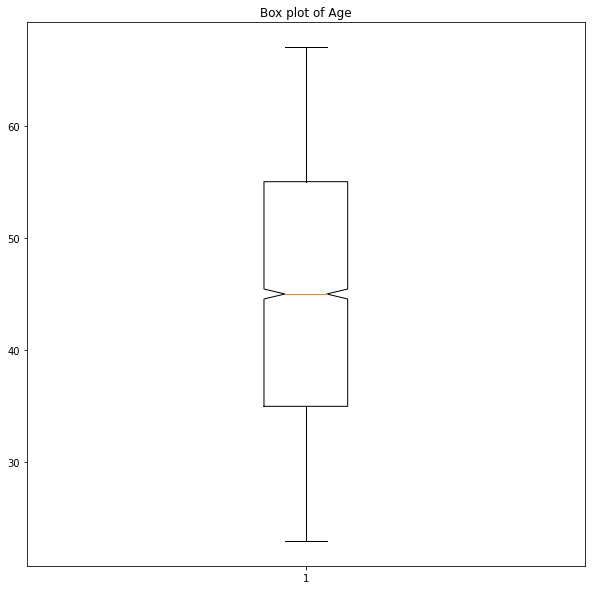

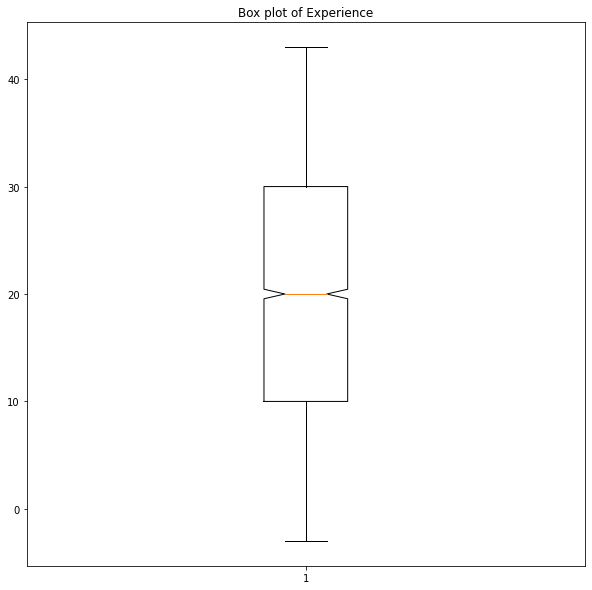

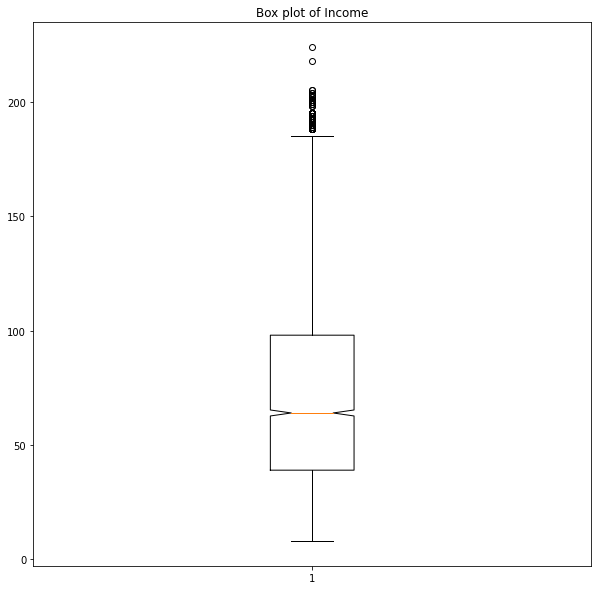

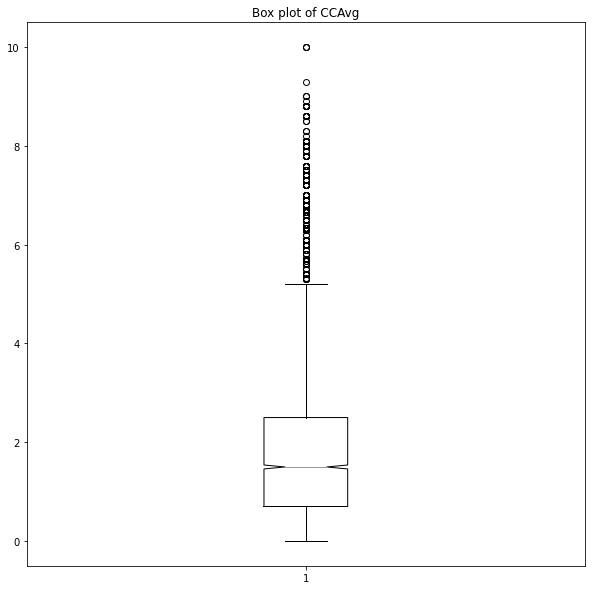

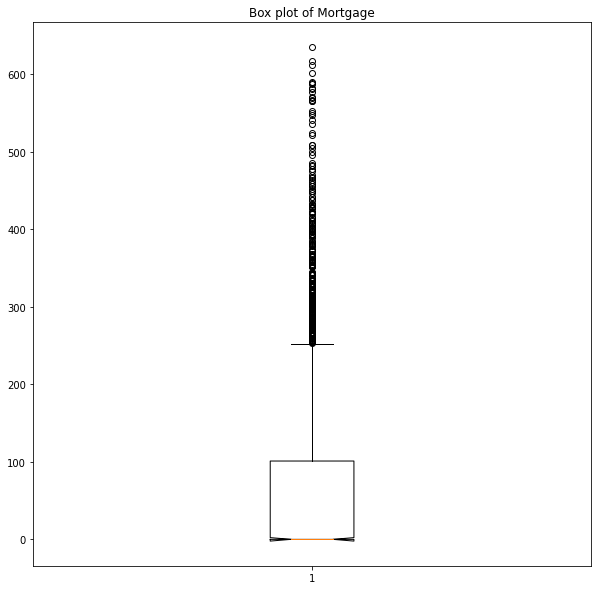

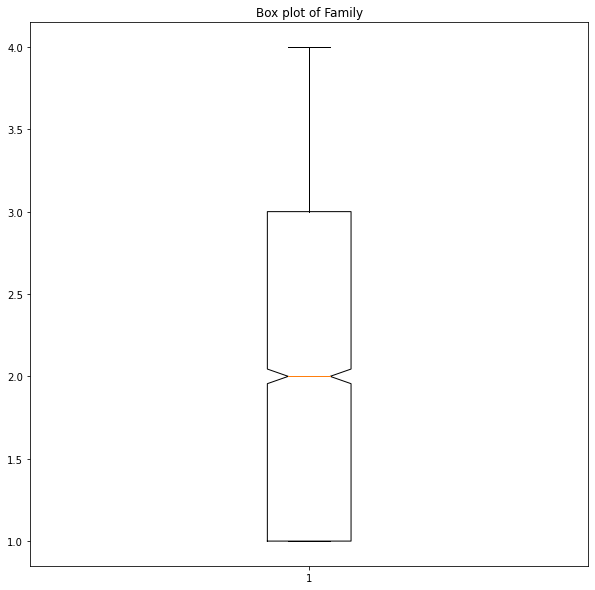

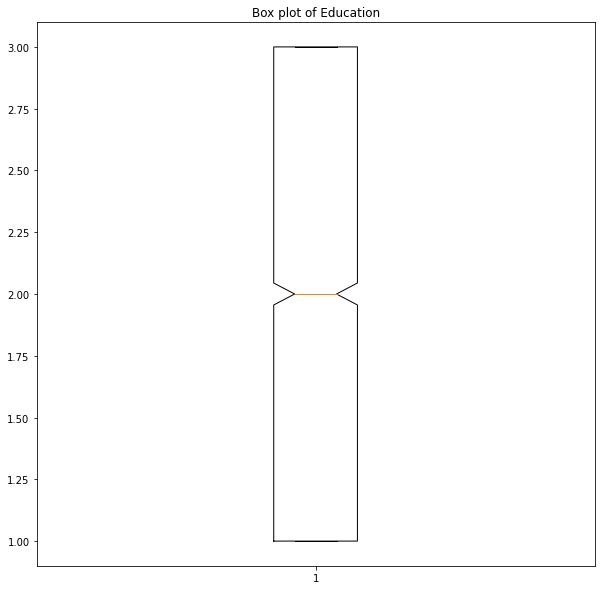

In [16]:
# Quickly graph boxplots of the data to visually insepct
for col in trimmed_bank_data.columns:
    # These get influced by the mean too hard since it's binary
    if col in ['Personal Loan','CD Account','Securities Account']:
        continue
    plt.figure(figsize=(10,10))
    plt.title(f"Box plot of {col}")
    plt.boxplot(trimmed_bank_data[col],notch=True)
    plt.show()

In [17]:
# Find values 3 standard deviations above/below the mean 
remove_indexes = []
for col in trimmed_bank_data.columns:
    # These get influced by the mean too hard since it's binary
    if col in ['Personal Loan','CD Account','Securities Account']:
        continue
    z = np.abs(zscore(trimmed_bank_data[col]))
    above_3_z = np.where(z > 3)
    remove_indexes += list(above_3_z[0])

# Create the list of values to remove
remove_indexes = np.array(remove_indexes)
remove_indexes = np.unique(remove_indexes)

In [18]:
trimmed_bank_data_no_outliers = trimmed_bank_data.drop(remove_indexes)
display(trimmed_bank_data_no_outliers)

# Try rerunning without the outlier rows
training_bank_data_no_outliers, testing_bank_data_no_outliers = train_test_split(trimmed_bank_data_no_outliers,test_size=.2)

# Run the algorithm
ID3_tree_bank_no_outliers = create_tree(training_bank_data_no_outliers)

pprint.pprint(ID3_tree_bank_no_outliers)

# Get the accuracy of the model
find_tree_accuracy(testing_bank_data_no_outliers,ID3_tree_bank_no_outliers)

,Age,Experience,Income,CCAvg,Mortgage,Securities Account,CD Account,Family,Education,Personal Loan
0,25,1,49,1.6,0,1,0,4,1,0
1,45,19,34,1.5,0,1,0,3,1,0
2,39,15,11,1.0,0,0,0,1,1,0
3,35,9,100,2.7,0,0,0,1,2,0
4,35,8,45,1.0,0,0,0,4,2,0
...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1.9,0,0,0,1,3,0
4996,30,4,15,0.4,85,0,0,4,1,0
4997,63,39,24,0.3,0,0,0,2,3,0
4998,65,40,49,0.5,0,0,0,3,2,0


{'Income <= 195': {'CCAvg <= 7.0': {'Mortgage <= 357': {'CD Account <= 1': {'Education <= 2': {'Age <= 65': {'Experience <= 41': {'Family <= 3': {'Securities Account <= 0': 0,
                                                                                                                                                  'Securities Account > 0': 0},
                                                                                                                                  'Family > 3': {'Securities Account <= 0': 0,
                                                                                                                                                 'Securities Account > 0': 0}}},
                                                                                               'Age > 65': 0},
                                                                            'Education > 2': {'Experience <= 41': {'Age <= 65': {'Family <= 3': {'Securities Account <= 1': 0},
         

In [18]:
different_sizes = [.5,.6,.7,.8,.9]

for size in different_sizes:
    print(f"Training size: {size * 100:.2f}%\nTesting Size: {(1 - size) * 100:.2f}%")
    # Split the data into training and testing
    training_bank_data, testing_bank_data = train_test_split(trimmed_bank_data,test_size=1-size)

    # Run the algorithm
    ID3_tree_bank = create_tree(training_bank_data)
    
    # Print the accuracies
    find_tree_accuracy(testing_bank_data,ID3_tree_bank)
    print()

Training size: 50.00%
Testing Size: 50.00%
The accuracy of the ID3 tree on the training data was: 89.96%
The total number of data points that could not be classified was 5, 0.20% of the testing data
The accuracy of the model of points that were classified was: 90.14% with 246 incorrectly classified points and 2249 correctly classified points

Training size: 60.00%
Testing Size: 40.00%
The accuracy of the ID3 tree on the training data was: 90.20%
The total number of data point that could not be classified was 1, 0.05% of the testing data
The accuracy of the model of points that were classified was: 90.25% with 195 incorrectly classified points and 1804 correctly classified points

Training size: 70.00%
Testing Size: 30.00%
The accuracy of the ID3 tree on the training data was: 89.87%
The total number of data points that could not be classified was 4, 0.27% of the testing data
The accuracy of the model of points that were classified was: 90.11% with 148 incorrectly classified points and 

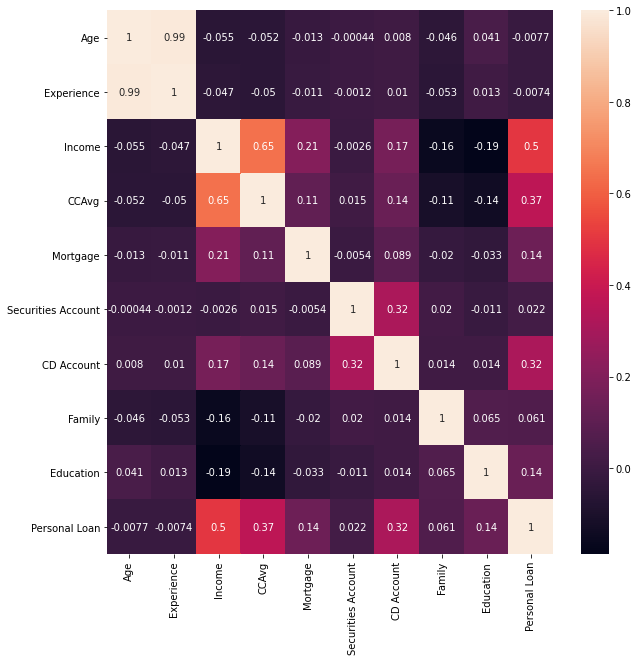

In [19]:
correlation_matrix = trimmed_bank_data.corr()
plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns, annot=True)
plt.show()

In [20]:
# Testing depth
# The depth does pre-pruning
# -1 means no depth requirement
depths = [2,3,4,5,6,7,-1]

# Remove some of the data that has no effect on classification
# Such as ID, Zip Code
important_columns = ['Age','Experience','Income','CCAvg','Mortgage','Securities Account','CD Account','Family','Education','Personal Loan']
trimmed_bank_data = bank_data[important_columns]

# Split the data into training and testing
training_bank_data, testing_bank_data = train_test_split(trimmed_bank_data,test_size=.2)

for depth_val in depths:
    # Run the algorithm
    ID3_tree_bank = create_tree(training_bank_data,depth=depth_val)
    print(f"Depth of {depth_val}")
    pprint.pprint(ID3_tree_bank)

    # Get the accuracy of the model
    find_tree_accuracy(testing_bank_data,ID3_tree_bank)
    print()
    
# Changing the depth doesn't seem to change too much for this data set. It might change more significantly for another data set.
# Also with the pre-pruning, it doesn't seem to make too much of a difference currently. Might change with another data set

Depth of 2
{'Income <= 202': {'CCAvg <= 8.6': 0, 'CCAvg > 8.6': 1},
 'Income > 202': {'Age <= 43': 0, 'Age > 43': 0}}
The accuracy of the ID3 tree on the training data was: 91.60%
The total number of data point that could not be classified was 0, 0.00% of the testing data
The accuracy of the model of points that were classified was: 91.60% with 84 incorrectly classified points and 916 correctly classified points

Depth of 3
{'Income <= 202': {'CCAvg <= 8.6': {'Mortgage <= 601': 0, 'Mortgage > 601': 1},
                   'CCAvg > 8.6': {'Experience <= 19': 1,
                                   'Experience > 19': 0}},
 'Income > 202': {'Age <= 43': {'Experience <= 5': 0, 'Experience > 5': 0},
                  'Age > 43': 0}}
The accuracy of the ID3 tree on the training data was: 91.60%
The total number of data point that could not be classified was 0, 0.00% of the testing data
The accuracy of the model of points that were classified was: 91.60% with 84 incorrectly classified points and

The accuracy of the ID3 tree on the training data was: 91.50%
The total number of data points that could not be classified was 2, 0.20% of the testing data
The accuracy of the model of points that were classified was: 91.68% with 83 incorrectly classified points and 915 correctly classified points



In [21]:
# Did not implement post-pruning. Not sure how I would go about doing it since I create my tree in an interesting way
# Tried doing it where it goes back through, but changing it to classes would probably have made this better